In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime, time
import skimage.io
import skimage.transform

import modutils

In [4]:
def tf_create_mobilenet_graph(model_fname):
    t_input = 'input:0'
    t_output = 'MobilenetV1/Predictions/Reshape:0'
    tf_graph_def = tf.GraphDef()
    with open(model_fname, 'rb') as f:
        tf_graph_def.ParseFromString(f.read())
    tf_input, tf_output = tf.import_graph_def(tf_graph_def, name='', return_elements=[t_input, t_output])
    
    return tf_input, tf_output


def tf_create_jpeg_load_graph(dst_dim):
    tf_input_jpeg = tf.placeholder(tf.string)
    tf_input_img = tf.cast(tf.image.decode_jpeg(tf_input_jpeg, channels=dst_dim[2]), dtype=tf.float32)
    tf_resized_img = tf.image.resize_bilinear(tf.expand_dims(tf_input_img, 0), tf.cast(tf.stack([dst_dim[0], dst_dim[1]]), dtype=tf.int32))
    tf_final_img = (tf_resized_img - 127.5) / 127.5
    return tf_input_jpeg, tf_final_img

def tf_get_features(img_fnames, model_fname, img_dim, verbose=False):
    tf.reset_default_graph()
    
    tf_input_cnn, tf_output_cnn = tf_create_mobilenet_graph(model_fname)
    tf_input_jpeg, tf_output_img = tf_create_jpeg_load_graph(img_dim)
    
    with tf.Session() as tfs:
        res = []
        num_current = 1
        num_total = len(img_fnames)
        for img_fname in img_fnames:
            img_data = None
            with open(img_fname, 'rb') as f:
                img_data = f.read()
            img_transformed = tf_output_img.eval(feed_dict={tf_input_jpeg:img_data})
            img_features = tf_output_cnn.eval(feed_dict={tf_input_cnn:img_transformed})
            res.append(img_features)
            if not verbose:
                print('{0} of {1} processed...'.format(num_current, num_total), end='\r')
                num_current += 1
    return np.vstack(res)

In [5]:
def read_img(fname, out_size = 128):
    f_img = skimage.io.imread(fname)
    if len(f_img.shape) != 3:
        print('Invalid dimensions in file "{0}"'.format(fname))
        return None
    req_size = max(f_img.shape[:2])
    misdim = req_size - f_img.shape[0]
    if misdim > 0:
        addtop = misdim // 2
        addbot = misdim - addtop
        if addtop > 0:
            f_img = np.vstack([np.tile(f_img[0], addtop).reshape(f_img.shape[1], addtop, 3).transpose([1,0,2]),
                                f_img,
                                np.tile(f_img[-1], addbot).reshape(f_img.shape[1], addbot, 3).transpose([1,0,2])])
        else:
            f_img = np.vstack([f_img, np.tile(f_img[-1], addbot).reshape(f_img.shape[1], addbot, 3).transpose([1,0,2])])
            
    misdim = req_size - f_img.shape[1]
    if misdim > 0:
        addl = misdim // 2
        addr = misdim - addl
        if addl > 0:
            f_img = np.hstack([np.tile(f_img[:, 0, :], addl).reshape(f_img.shape[0], addl, 3),
                              f_img,
                              np.tile(f_img[:, -1, :], addr).reshape(f_img.shape[0], addr, 3)])
        else:
            f_img = np.hstack([f_img, np.tile(f_img[:, -1, :], addr).reshape(f_img.shape[0], addr, 3)])
    return skimage.transform.resize(f_img, output_shape=(out_size, out_size), mode='constant', order = 1)

def transform_img(img):
    return skimage.color.rgb2gray(img).reshape(1,-1)

def transform_batch(dst_format, src_files, src_data, batch_size=1024):
    num_batches = len(src_files) // batch_size
    if num_batches * batch_size < len(src_files):
        num_batches += 1
    for i in range(num_batches):
        start = i * batch_size
        end = (i + 1) * batch_size
        imgs = np.vstack([transform_img(read_img(x)) for x in src_files[start:end]])
        data = np.hstack([src_data[start:end], imgs])
        np.save(dst_format.format(i), data)
        print('Processed batch {}/{}'.format(i+1, num_batches), end='\r')
    print('Processing complete')

In [15]:
def tf_transform_batch(dst_format, src_files, src_data, model_fname, img_dim, batch_size=512):
    num_batches = len(src_files) // batch_size
    if num_batches * batch_size < len(src_files):
        num_batches += 1
        
    tf.reset_default_graph()
    
    tf_input_cnn, tf_output_cnn = tf_create_mobilenet_graph(model_fname)
    tf_input_jpeg, tf_output_img = tf_create_jpeg_load_graph(img_dim)
    
    for i in range(num_batches):
        start = i * batch_size
        end = (i + 1) * batch_size
        img_fnames = src_files[start:end]
        try:
            with tf.Session() as tfs:
                res = []
                num_current = 1
                num_total = len(img_fnames)
                for img_fname in img_fnames:
                    img_data = None
                    with open(img_fname, 'rb') as f:
                        img_data = f.read()
                    img_transformed = tf_output_img.eval(feed_dict={tf_input_jpeg:img_data})
                    img_features = tf_output_cnn.eval(feed_dict={tf_input_cnn:img_transformed})
                    res.append(img_features)
            imgs = np.vstack(res)
            data = np.hstack([src_data[start:end], imgs])
        except:
            print('batch failed')
        np.save(dst_format.format(i), data)
        print('Processed batch {}/{}'.format(i+1, num_batches))

In [6]:
src = pd.read_csv('D:/Jupyter/DataSets/prv/data_mf.csv', sep=';')

In [14]:
%%time
batch_size = 
res = tf_get_features(src.local_url[:1000].values, 'D:/Jupyter/DataSets/prv/graph_mobilenet_0.50_224.pb',
                img_dim=(224,224,3), verbose=True)

Wall time: 15.6 s


In [16]:
tf_transform_batch('D:/Jupyter/DataSets/prv/mobnet_batch{0:03d}.npy',
                   src.local_url, src[['trg_m','trg_f']].values,
                  'D:/Jupyter/DataSets/prv/graph_mobilenet_0.50_224.pb',
                  img_dim=(224,224,3), batch_size=512)

Processed batch 1/101
Processed batch 2/101
Processed batch 3/101
Processed batch 4/101
Processed batch 5/101
Processed batch 6/101
Processed batch 7/101
Processed batch 8/101
Processed batch 9/101
Processed batch 10/101
Processed batch 11/101
Processed batch 12/101
Processed batch 13/101
Processed batch 14/101
Processed batch 15/101
Processed batch 16/101
Processed batch 17/101
Processed batch 18/101
Processed batch 19/101
Processed batch 20/101
Processed batch 21/101
Processed batch 22/101
Processed batch 23/101
Processed batch 24/101
Processed batch 25/101
Processed batch 26/101
Processed batch 27/101
Processed batch 28/101
Processed batch 29/101
Processed batch 30/101
Processed batch 31/101
Processed batch 32/101
Processed batch 33/101
Processed batch 34/101
Processed batch 35/101
Processed batch 36/101
Processed batch 37/101
Processed batch 38/101
Processed batch 39/101
Processed batch 40/101
Processed batch 41/101
Processed batch 42/101
Processed batch 43/101
Processed batch 44/1

In [135]:
transform_batch('D:/Jupyter/DataSets/prv/dev0_batch{0:03d}.npy',
                src.local_url, src[['trg_m','trg_f']].values)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Jupyter\\Datasets\\prv\\u0563955_002437761.jpg'

In [131]:
src[['rid','trg_m','trg_f']].values[:200].shape

(200, 3)

In [68]:
%%time
test_X = np.vstack([readimg(x).reshape(1,-1) for x in src.local_url[1000:2000]])

Wall time: 2min 33s


In [69]:
train_Y1 = src.trg_m[:1000].values.reshape(-1)
train_Y2 = src.trg_f[:1000].values.reshape(-1)
test_Y1 = src.trg_m[1000:2000].values.reshape(-1)
test_Y2 = src.trg_f[1000:2000].values.reshape(-1)

In [54]:
train_X.shape, train_Y1.shape

((1000, 49152), (1000, 1))

In [64]:
import sklearn, sklearn.linear_model, sklearn.metrics

In [84]:
%%time
lr1 = sklearn.linear_model.LogisticRegression(penalty='l1', C=1).fit(train_X, train_Y1)

Wall time: 6.24 s


In [85]:
train_P = lr1.predict_proba(train_X)[:,1]
test_P = lr1.predict_proba(test_X)[:,1]

In [86]:
sklearn.metrics.roc_auc_score(train_Y1, train_P)*2-1,\
sklearn.metrics.roc_auc_score(test_Y1, test_P)*2-1

(0.99961915349143626, -0.012196356498047956)

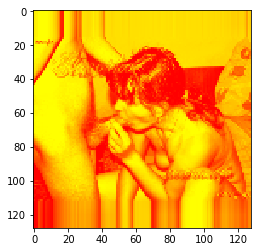

In [119]:
plt.imshow(tmp2, cmap='autumn')

In [94]:
tmp1.shape

(128, 128)